# Multitask - the OxfordIIITPet dataset for segmentation and classification

In [1]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.transforms import v2
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt

In [2]:
class MultiTaskDataset(Dataset):
    def __init__(self, split):
        self.data = OxfordIIITPet(
            root="../data",
            download=True,
            split=split,
            target_types=("category", "segmentation"),
        )
        self.transforms = v2.Compose([
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Resize([224, 224]),
        ])
        # Important! We also use a random data augmentation! we need to apply the same transformation to the image and the segmentation mak

        self.random_transforms = v2.Compose([
            v2.RandomHorizontalFlip(p=0.5),
        ])
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        image, (class_label, segmentation_mask) = self.data[i]


        image = self.transforms(image)
        segmentation_mask = self.transforms(segmentation_mask)

        # # This is wrong
        # image = self.random_transforms(image)
        # segmentation_mask = self.random_transforms(segmentation_mask)
        # # If we do this, we might flip the image, but not flip the segmentation mask!!!
        # # We need to flip both, or flip none

        image_and_mask = torch.cat([image, segmentation_mask])  
        # We concatenate the image and the segmentation mask and perform data augmentation on both, treating the segmentation mask as a 4th channel.
        image_and_mask = self.random_transforms(image_and_mask)
        image = image_and_mask[:3]
        segmentation_mask = image_and_mask[3:]

        return image, class_label, segmentation_mask

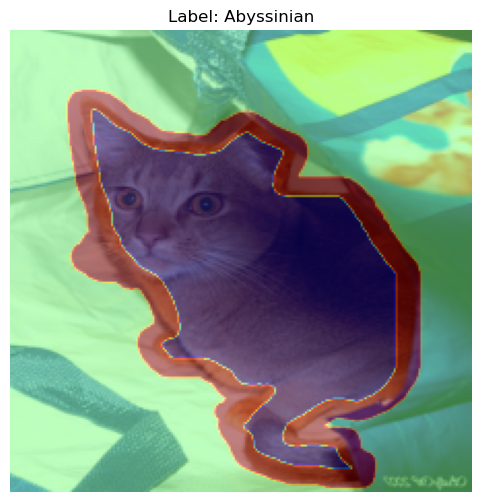

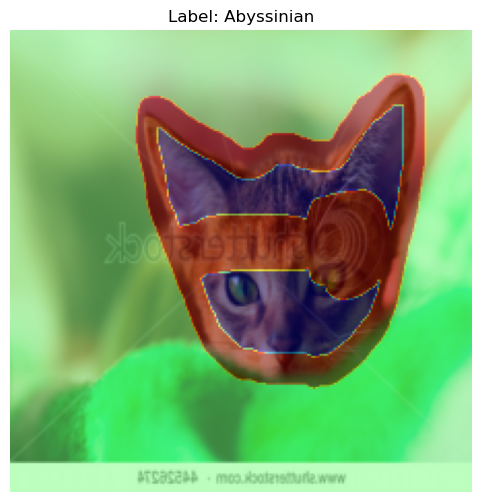

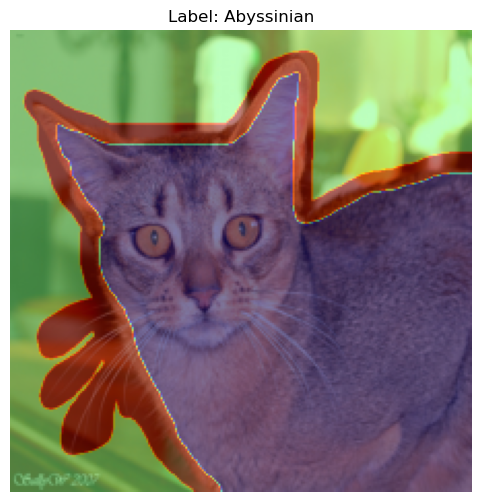

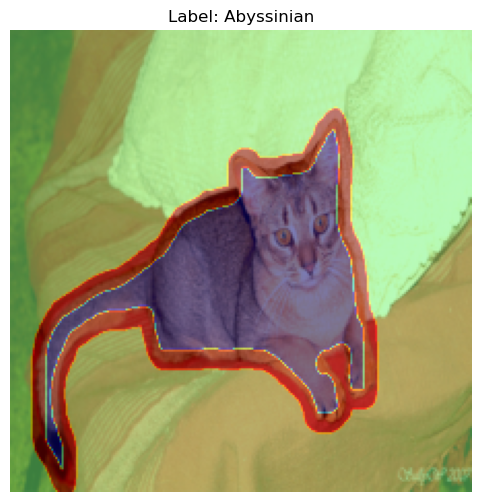

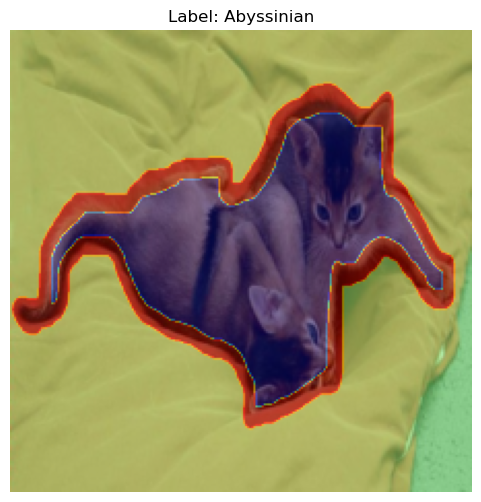

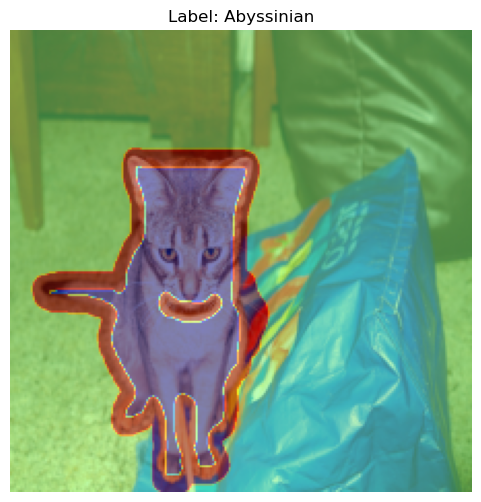

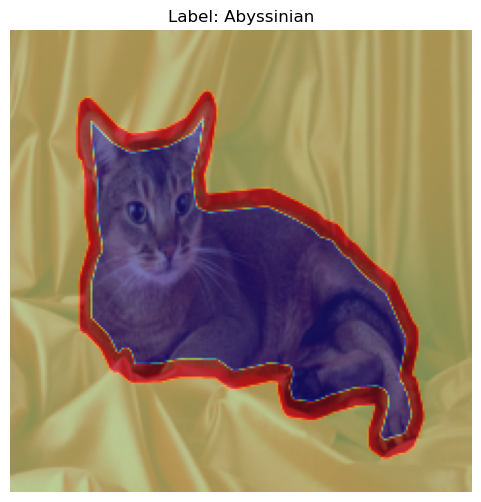

In [ ]:
dataset = MultiTaskDataset("trainval")
for i, (image, class_label, segmentation_mask) in enumerate(dataset):
    plt.figure(figsize=(6, 6))
    plt.imshow(image.permute(1, 2, 0).clamp(0, 1))
    plt.imshow(segmentation_mask.squeeze(0), cmap="jet", alpha=0.5)
    plt.title(f"Label: {dataset.data.classes[class_label]}")
    plt.axis("off")
    plt.show()
    if i > 5:
        break

In [ ]:
class MultiTaskModel(nn.Module):
    def __init__(self, num_classes=37):
        super().__init__()
        resnet = models.resnet18(weights="IMAGENET1K_V1")
        self.backbone = nn.Sequential(
            *list(resnet.children())[:-2]
        )

        self.segmentation_head = nn.Sequential(
            nn.Conv2d(512, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 1, kernel_size=1),
            nn.Upsample(scale_factor=32, mode="bilinear", align_corners=False),
        )

        self.classification_head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(), nn.Linear(512, num_classes)
        )

    def forward(self, x):
        feats = self.backbone(x)
        mask = self.segmentation_head(feats)
        cls = self.classification_head(feats)
        return cls, mask